# Inspect Prostate Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

DATA_DIR = 'C:\CLUSTERDATA\BIOMARKERS\RP\mrcnn_data'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

import prostate
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

%matplotlib inline 

In [2]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

## Configurations

In [3]:
config = prostate.ProstateConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      3
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [320 320   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [5]:
# Load dataset
dataset = prostate.ProstateDataset()
# The subset is the name of the sub-directory, train or eval
dataset.load_prostate(IMAGES_DIR, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 744
Class Count: 4
  0. BG                                                
  1. prostate                                          
  2. pz                                                
  3. roi                                               


## Display Samples

C:\Users\mxa4898\Documents\medphys\prostate\Mask_RCNN\mrcnn\visualize.py:53: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image.astype(np.uint8), cmap=cmap,
C:\Users\mxa4898\Documents\medphys\prostate\Mask_RCNN\mrcnn\visualize.py:53: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image.astype(np.uint8), cmap=cmap,


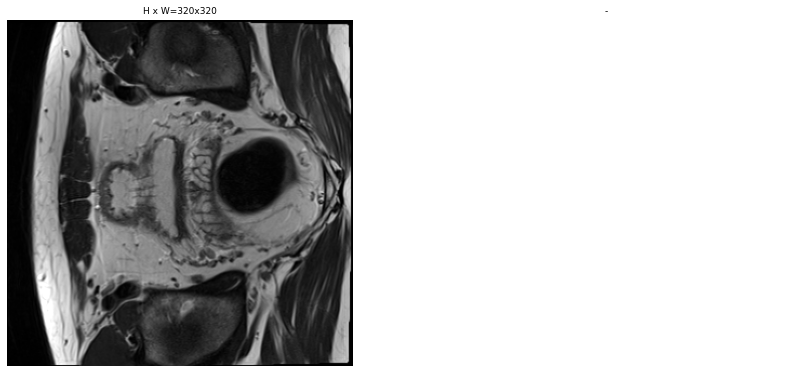

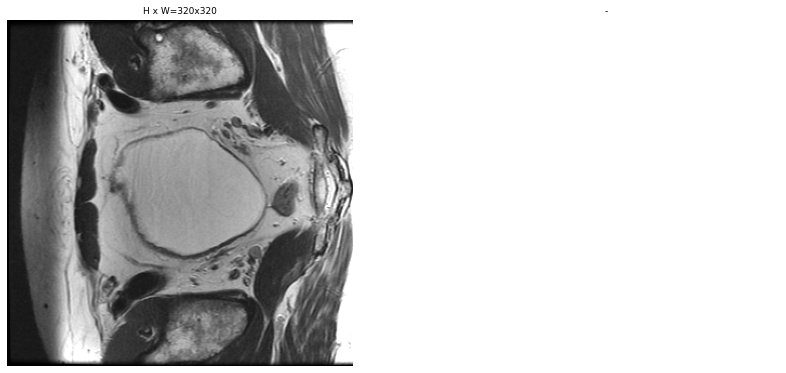

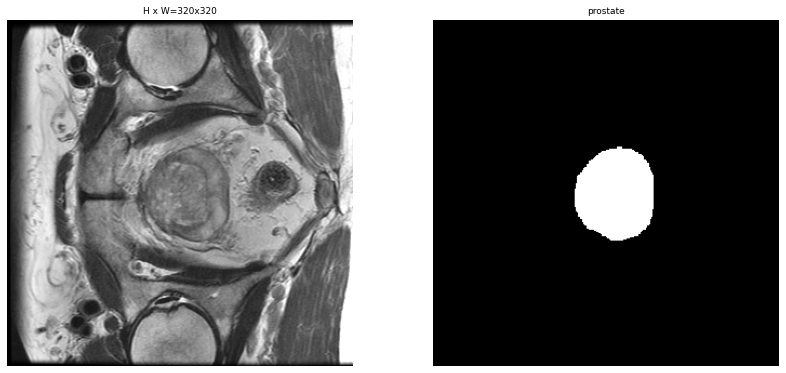

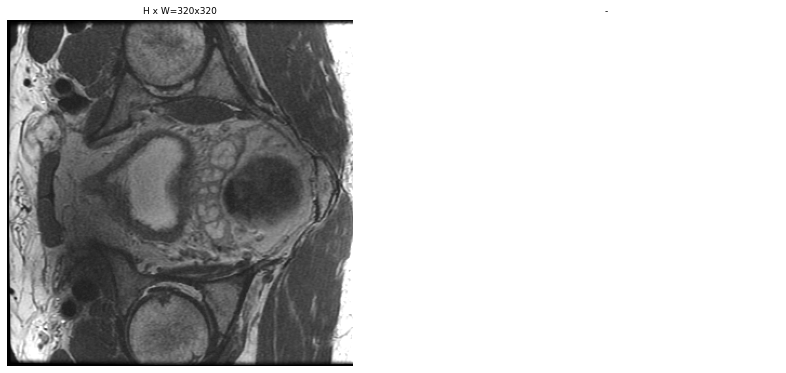

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image[:,:,0], mask, class_ids, dataset.class_names, limit=1, cmap='gray')

molded_image             shape: (320, 320, 4)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (320, 320, 3)         min:    0.00000  max:    1.00000  bool


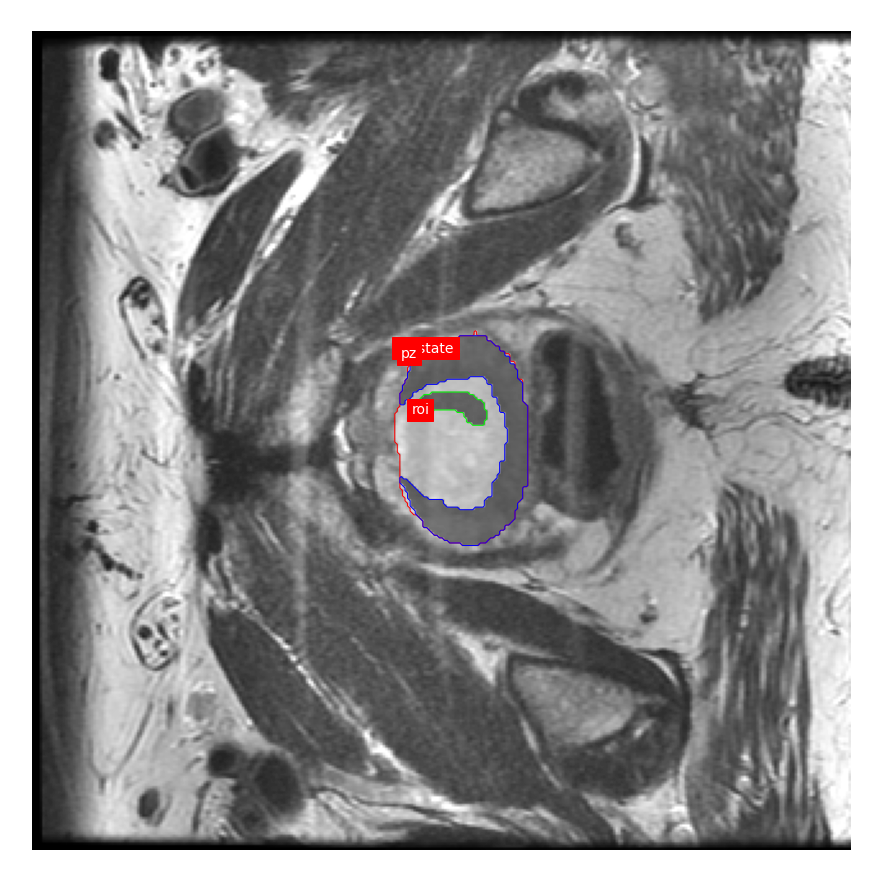

In [7]:
# Example of loading a specific image by its unique ID
unique_id = '02.08'

# Map source ID to Dataset image_id
image_id = dataset.image_from_source_map['mri.{}'.format(unique_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False, cmap='gray', channel=0)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [8]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
#     assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 2.0 seconds


### Image Size Stats

Image Count:  744
Height  mean: 320.00  median: 320.00  min: 320.00  max: 320.00
Width   mean: 320.00  median: 320.00  min: 320.00  max: 320.00
Color   mean (RGB): 95.75 84.46 88.44 89.76


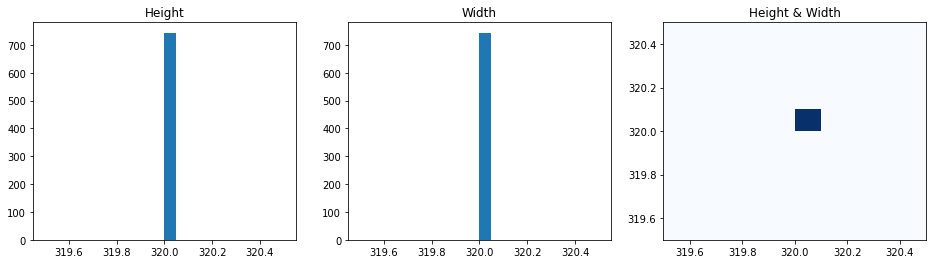

In [9]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Contour Stats

Contours/image
mean: 1.2  median: 0.0  min: 0.0  max: 7.0


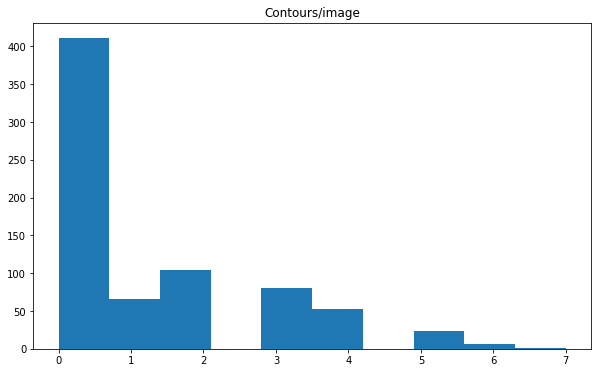

In [12]:
print('Contours/image')
fig, ax = plt.subplots(figsize=(10, 6))

contours_per_image = np.array([len(s['bbox']) 
                             for s in stats])

print("mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
    contours_per_image.mean(), np.median(contours_per_image), 
    contours_per_image.min(), contours_per_image.max()))
ax.set_title("Contours/image")
_ = ax.hist(contours_per_image, bins=10)

  Total Contours:  886
  Contour Height. mean: 49.79  median: 53.00  min: 2.00  max: 111.00
  Contour Width.  mean: 40.88  median: 42.00  min: 2.00  max: 98.00
  Contour Area.   mean: 2513.42  median: 2343.00  min: 4.00  max: 10878.00


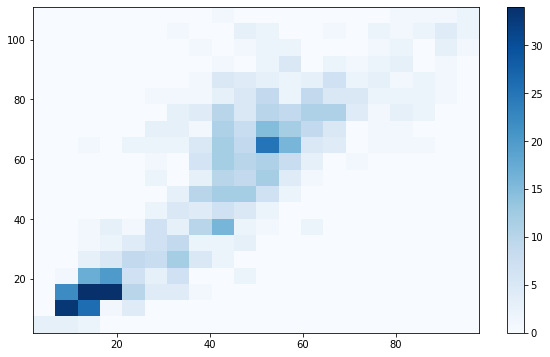

In [11]:
# Contour size stats
fig, ax = plt.subplots(figsize=(10, 6))

contour_shape = np.array([
    b 
    for s in stats
    for b in s['bbox']])
contour_area = contour_shape[:,0] * contour_shape[:, 1]

print("  Total Contours: ", contour_shape.shape[0])
print("  Contour Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(contour_shape[:, 0]), np.median(contour_shape[:, 0]),
    np.min(contour_shape[:, 0]), np.max(contour_shape[:, 0])))
print("  Contour Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(contour_shape[:, 1]), np.median(contour_shape[:, 1]),
    np.min(contour_shape[:, 1]), np.max(contour_shape[:, 1])))
print("  Contour Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(contour_area), np.median(contour_area),
    np.min(contour_area), np.max(contour_area)))

# Show 2D histogram
h = ax.hist2d(contour_shape[:, 1], contour_shape[:, 0], bins=20, cmap="Blues")
fig.colorbar(h[3], ax=ax)

Contour Aspect Ratio.  mean: 1.21  median: 1.16  min: 0.40  max: 4.47


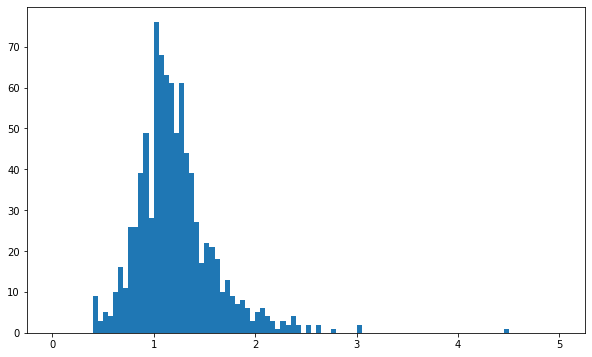

In [13]:
# Contour height/width ratio
contour_aspect_ratio = contour_shape[:, 0] / contour_shape[:, 1]
print("Contour Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(contour_aspect_ratio), np.median(contour_aspect_ratio),
    np.min(contour_aspect_ratio), np.max(contour_aspect_ratio)))
plt.figure(figsize=(10, 6))
_ = plt.hist(contour_aspect_ratio, bins=100, range=[0, 5])

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  25575
Scales:  (4, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 19200
Anchors in Level 1: 4800
Anchors in Level 2: 1200
Anchors in Level 3: 300
Anchors in Level 4: 75
Level 0. Anchors:  19200  Feature map Shape: [80 80]
Level 1. Anchors:   4800  Feature map Shape: [40 40]
Level 2. Anchors:   1200  Feature map Shape: [20 20]
Level 3. Anchors:    300  Feature map Shape: [10 10]
Level 4. Anchors:     75  Feature map Shape: [5 5]


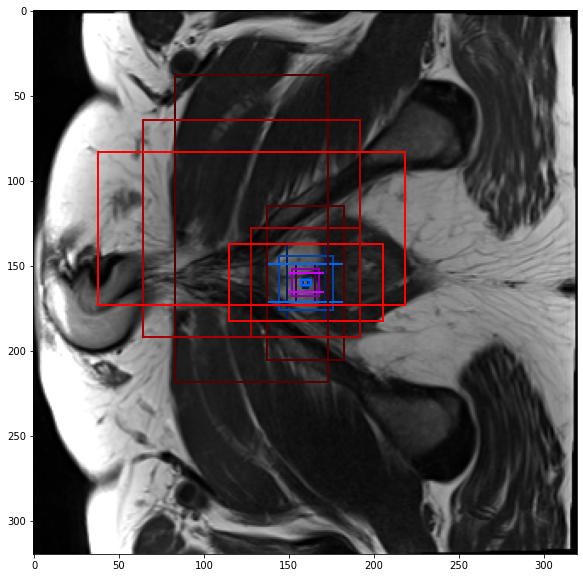

In [14]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# # Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image[:,:,0],cmap='gray')
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [15]:
# Create data generator
random_rois = 2000
g = modellib.DataGenerator(dataset, config, shuffle=True, 
           random_rois=random_rois,detection_targets=True)

In [16]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = g.__getitem__(0)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (6, 200, 4)           min:    0.00000  max:  319.00000  int32
mrcnn_class_ids          shape: (6, 200, 1)           min:    0.00000  max:    3.00000  int32
mrcnn_bbox               shape: (6, 200, 4, 4)        min:   -3.21938  max:    3.01887  float32
mrcnn_mask               shape: (6, 200, 56, 56, 4)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (6, 10)               min:    0.00000  max:    3.00000  int32
gt_boxes                 shape: (6, 10, 4)            min:    0.00000  max:  206.00000  int32
gt_masks                 shape: (6, 320, 320, 10)     min:    0.00000  max:    1.00000  bool
rpn_match                shape: (6, 25575, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (6, 256, 4)           min:   -2.18750  max:    2.65165  float64
image_id:  301 None


anchors                  shape: (25575, 4)            min:  -90.50967  max:  346.50967  float64
refined_anchors          shape: (1, 4)                min:  136.00000  max:  199.99998  float32
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 25319
BG                     : 176
prostate               : 24


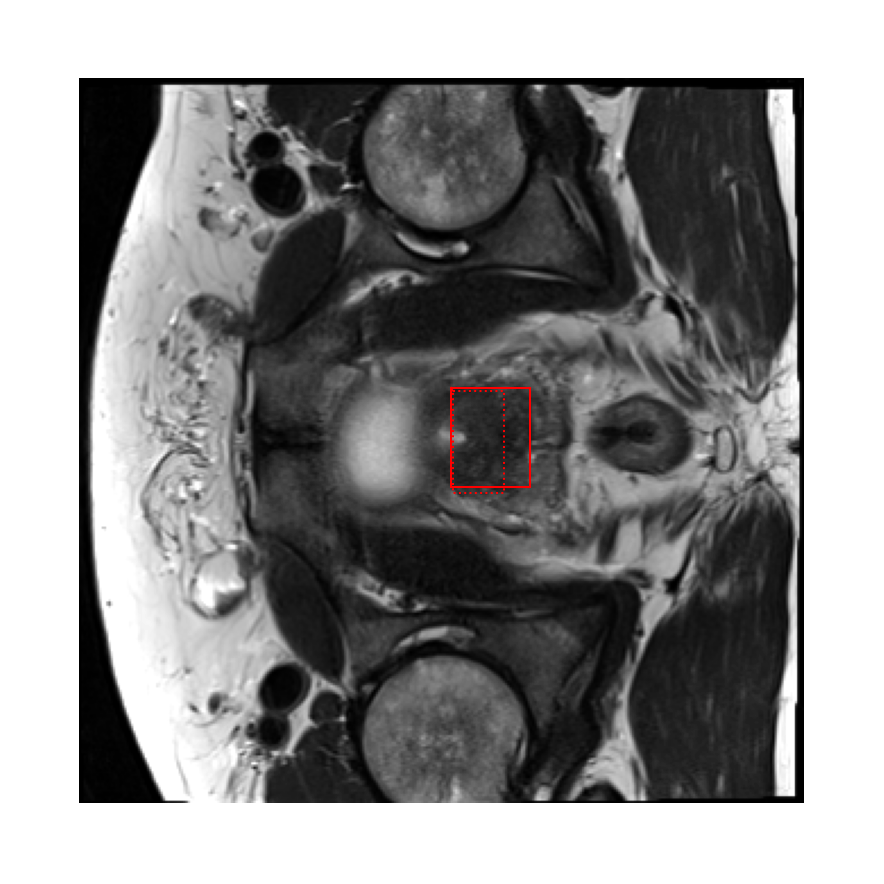

In [17]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax, channel=0, cmap='gray')

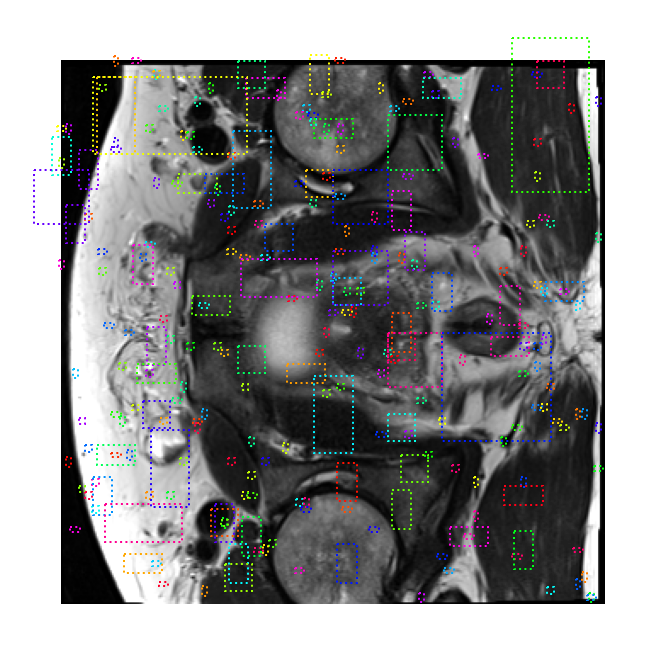

In [18]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids], channel=0, cmap='gray')

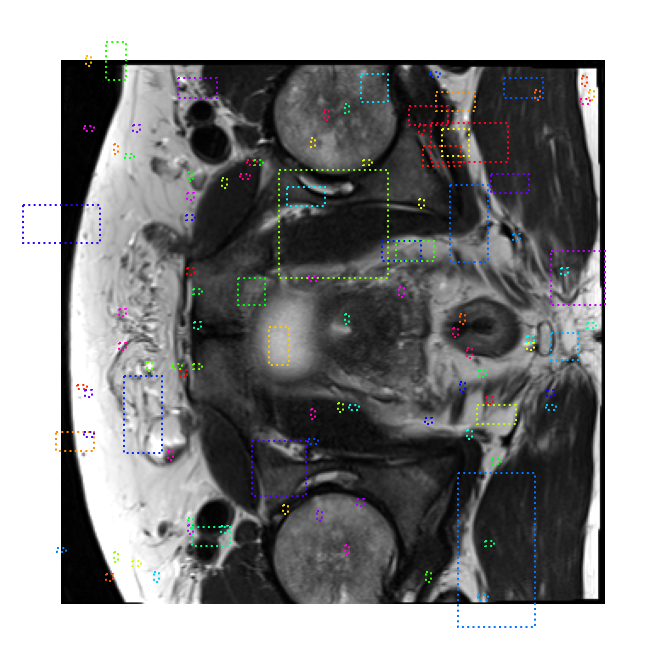

In [19]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)], channel=0, cmap='gray')

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  24
Negative ROIs:  176
Positive Ratio: 0.12
Unique ROIs: 200 out of 200


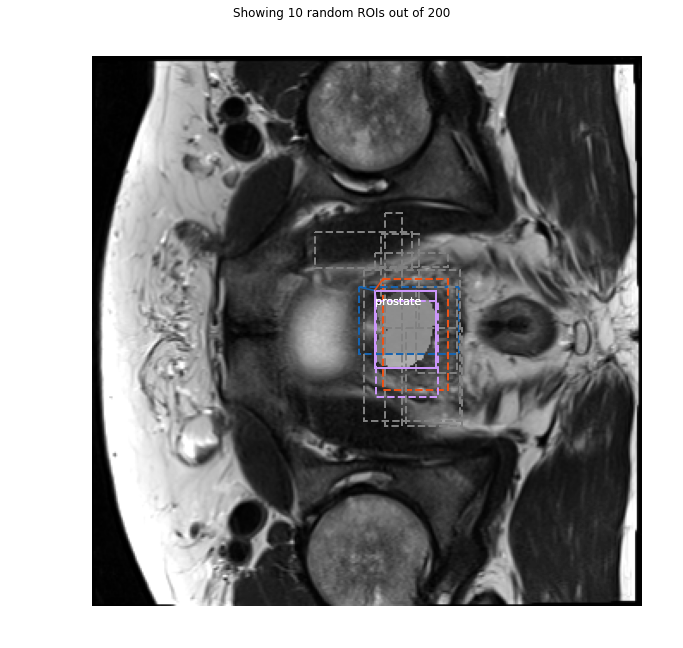

In [20]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names, channel=0, cmap='gray')
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [21]:
sample_image.shape

(320, 320, 4)

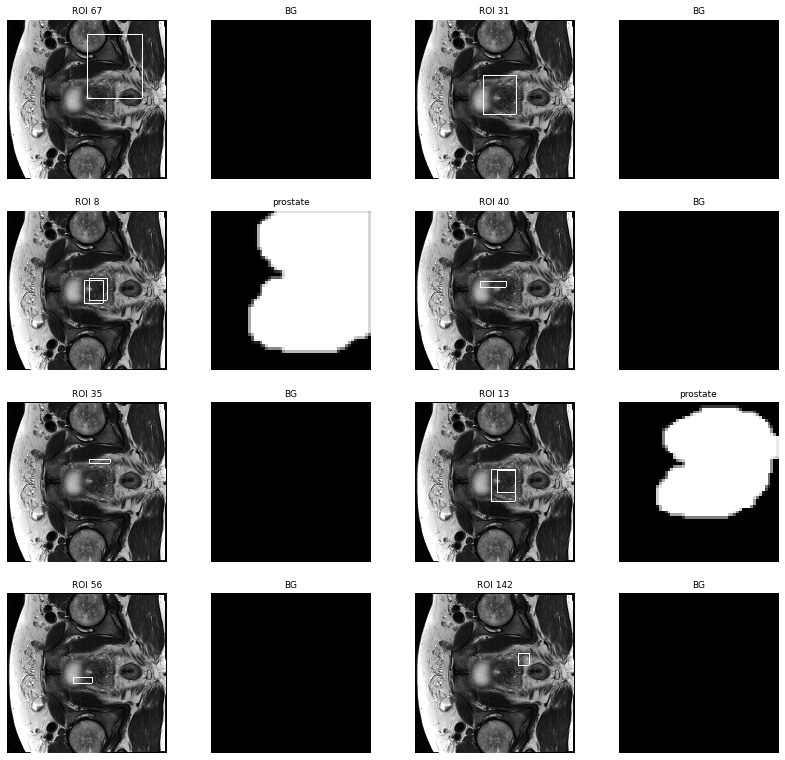

In [22]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy()[:,:,:3], rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image[:,:,:3], refined_rois[i].astype(np.int64), [255, 255,255])
        images.append(image[:,:,0])
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="gray", interpolation="none")

In [23]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(dataset, config, shuffle=True, 
           random_rois=random_rois,detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = g.__getitem__(i)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   23  0.12
   31  0.15
   20  0.10
   25  0.12
   23  0.12
   23  0.12
   26  0.13
   22  0.11
   14  0.07
   26  0.13
Average percent: 0.12
